### A notebook to build a network of climate change expert profiles 

#### Created for  @IsThisAnExpert, winner project of the Goethe's Institute [ClimateChange Hackaton](https://www.goethe.de/prj/one/en/gea/for/clc.html)

This notebook uses the Twitter API to querz the list of [friends](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-friends-ids) of f climate experts twitter profiles from a manually curated selection.

The aim is to expand the list of experts based on the climate expert Twitter network.

The output is a CSV file with a list of twitter handles shared among the experts
the list needs to be manually reviewed and crossreferenced with other information such as origin of the twitter handles, user afiliations and so on.


In [ ]:
#!/usr/bin/env python3.7
import tweepy
import sys
import os, json
import pandas as pd
import subprocess
from collections import Counter
import time
import matplotlib.pyplot as plt
import numpy as np
 from dotenv import load_dotenv
# load environment variables
load_dotenv()

# Setup API:
def twitter_setup():
    # Authenticate and access using keys:
    auth = tweepy.OAuthHandler(os.getenv('CONSUMER_KEY'), os.getenv('CONSUMER_SECRET'))
    auth.set_access_token(os.getenv('ACCESS_TOKEN'), os.getenv('ACCESS_SECRET'))
    auth.secure = True
    # Return API access:
    # use wait_on_rate_limit to avoid getting banned
    api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
    return api



def get_user_network(user_id):

    print("Searching network for user with id " + str(user_id))

    friends = []
    max_friends = 100000
        
    try:

        for page in tweepy.Cursor(api.friends_ids, screen_name=user_id).pages():
            friends.extend(page)
            if len(friends) >= max_friends:
                break
            print("Friends so far : " + str(len(friends)))
        print("finished friends")
    except tweepy.TweepError as tweep_error:
        print("Error with code : " + str(tweep_error.response.text))
        return 0
    print("User with ID: " + user_id + " has " + str(len(friends)) + " friends")

    custom_object = {
        user_id: friends
    }
    return custom_object

# set api entry point
api = twitter_setup()

# open csv file with the twitter handles
twitter_handles = pd.read_csv('/home/franasa/Downloads/TwitterHandles.csv')
handles_list=twitter_handles.TwitterHandle.tolist()
#create a dictionary to store user:user's friends
user_dict={}

######### uncomment these lines to save the query results as a json file ############
    
# with open('user_friends.json', 'r') as fil:
#     friends_json = json.load(fil)
    

# for user_name in handles_list:    
#     if not user_name in friends_json:
#         friends_json[user_name]=get_user_network(user_name)
#         with open('user_friends.json', 'w') as fil:
#             json.dump(friends_json, fil)


In [ ]:
## open the json file 
with open('user_friends.json', 'r') as fil:
    friends_json = json.load(fil)
    
## fix dictionary to put everything atthe same level and ignore missing handles
fix_dict={}
for user_name in friends_json:
    if type(friends_json[user_name])==list:
        fix_dict[user_name]={'friends_list': friends_json[user_name]}

    elif type(friends_json[user_name])==dict:

        fix_dict[user_name]={'friends_list': friends_json[user_name][user_name]}
    else:
        print(user_name, friends_json[user_name])

# ad to the dictionary the numeric user identifiers
for x in fix_dict:
    # fetching the user 
    user = api.get_user(x) 
    fix_dict[x]['id']= user.id 


@dr_nerilie 0


In [53]:
user_ids=[fix_dict[x]['id'] for x in fix_dict]
friends_list = [fix_dict[x]['friends_list'] for x in fix_dict if fix_dict[x]['friends_list']]
counter = Counter(friends_list[0])
for i in friends_list[1:]: 
    counter.update(i)

shared_friends=[x for x in counter.most_common() if x[1] >20]

print(len(shared_friends))


dicto_df={}
count=0
for friend in shared_friends:
    user = api.get_user(friend[0]) 
    count+=1
    
    if friend[0] in user_ids:
        indb=True
    else: indb=False
#     fix_dict[x]['id']= user.screen_name 
    dicto_df[count]={
        'friend_screen_name': user.screen_name ,
        'friend_id': friend[0],
        'appereance_count': friend[1],
        'in_database': indb ## is this an expert from the manually curated database
    }

269


In [56]:
## save the networking dataframe to a CSV file
shared_climate_friends=pd.DataFrame.from_dict(dicto_df, orient='index')
shared_climate_friends.to_csv("shared_climate_friends.csv", index=False)

shared_climate_friends

,friend_screen_name,friend_id,appereance_count,in_database
1,IPCC_CH,192942213,64,True
2,UNFCCC,17463923,61,True
3,GretaThunberg,1006419421244678144,59,False
4,guardianeco,20582958,59,False
5,KHayhoe,34317032,57,True
...,...,...,...,...
265,BAS_News,229045433,21,True
266,PEspinosaC,214842351,21,True
267,guardiannews,788524,21,False
268,smithsonian,14199378,21,False


Text(0, 0.5, 'Expert profile')

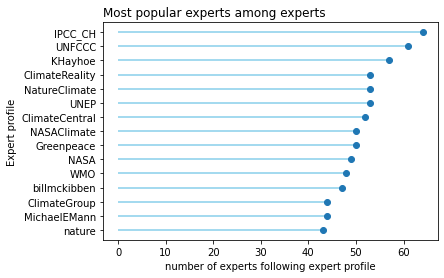

In [63]:
  
# Create a dataframe
df =shared_climate_friends[shared_climate_friends['in_database']==True].head(15)
# Reorder it following the values:
ordered_df = df.sort_values(by='appereance_count')
my_range=range(1,len(df.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['appereance_count'], color='skyblue')
plt.plot(ordered_df['appereance_count'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['friend_screen_name'])
plt.title("Most popular experts among experts", loc='left')
plt.xlabel('number of experts following expert profile')
plt.ylabel('Expert profile')


Text(0, 0.5, 'Twitter Profile')

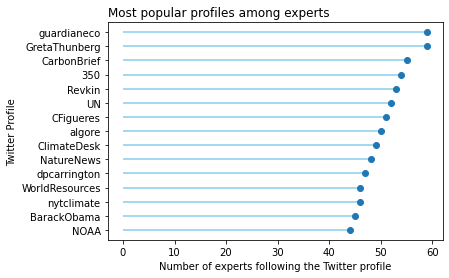

In [66]:
# Create a dataframe
df =shared_climate_friends[shared_climate_friends['in_database']==False].head(15)
# Reorder it following the values:
ordered_df = df.sort_values(by='appereance_count')
my_range=range(1,len(df.index)+1)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['appereance_count'], color='skyblue')
plt.plot(ordered_df['appereance_count'], my_range, "o")
 
# Add titles and axis names
plt.yticks(my_range, ordered_df['friend_screen_name'])
plt.title("Most popular profiles among experts", loc='left')
plt.xlabel('Number of experts following the Twitter profile')
plt.ylabel('Twitter Profile')
